# Union of K intervals


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [42]:
def made_intervals(permuted_ex):
    made_intervals = [permuted_ex[:-1,2] != permuted_ex[1:,2]]#compare labels
    startstop = [0] + [i if i %2 == 1 else 0 for i in np.cumsum(made_intervals)]
    _, groups = np.unique(startstop, return_inverse = True)#dont exclude 0 group, need to leave in for spaceing
    num_vals = max(groups)
    indicies = [[] for i in range(num_vals+1)]#list of list of intervals locs [most specific]
    for counter, val in enumerate(groups):
        indicies[val].append(counter)#appends row index of interval at its group
    return indicies
    
    
class union_interval:
    "Assumes a uniform distribution of samples"
    def __init__(self, k = 3, epsilon = 0.1, gamma = 0.1, space = [-5,5], noise = 0, exact_n = True, const_w = False):
        self.intervals = np.sort(np.random.uniform(space[0],space[1],2*k)).reshape(k,2)#intervals always smaller than sample space
        self.ep = epsilon
        self.gamma = gamma
        self.space = space #[space[0] + 0.0001, space[1] - 0.001]#ensure bu
        self.noise = noise
        self.exact_n = exact_n
        self.const_w = const_w
        self.k = k
        self.examples = np.array((self.space[0] - 0.01, 0, 0)).reshape(1,-1)#will always be ignored, put in so first example is always false

    def reset_examples(self):
        self.examples = np.array((self.space[0] - 0.01, 0, 0)).reshape(1,-1)
        
    def add_example(self, ex):
        if ex.ndim == 1:#1d array
            self.examples = np.vstack((self.examples, ex))
        elif ex.ndim == 2:#2d array
            self.examples = np.concatenate((self.examples, ex), axis =0)#needs to be list
            
            
    def bin_search(intervals, i, k = 0):
        j = len(intervals)
        if j <= 1:
            return k
        if i < intervals[j//2]:
            return union_interval.bin_search(intervals[:j//2], i, k)
        else:
            return union_interval.bin_search(intervals[j//2:], i, k + j//2)
        
        
    def in_intervals(intervals, i):
        indx = union_interval.bin_search(intervals[:,0], i)
        return intervals[indx, 0] <= i <= intervals[indx, 1]
        
        
    def sample(self, m = 1, samp = None, weight = None, label = None):
        if m == 1:
            samp = samp or np.random.uniform(self.space[0], self.space[1])#change sampling distribution here
            weight = float(weight or self.const_w or np.random.uniform(0,1))#wieghts random between 0 and 1
            label = label or in_intervals(union_interval.intervals, samp)
            self.add_example(np.array((samp, weight, label)))
        else:
            samples = np.random.uniform(*self.space, m)#change sampling distribution here
            weights = np.random.uniform(int(self.const_w), 1, m)
            labels = np.array([union_interval.in_intervals(self.intervals, i) for i in np.array(samples)])
            self.add_example(np.column_stack((samples, weights, labels)))                   
    

    def estimate_intervals(self):
        "Uses tight bounds for determining region"#" as else might not be PAC learnable given divergent Distribution?"
        self.examples = self.examples[np.argsort(self.examples[:,0]), :]#might as well keep it sorted
        rand = np.random.choice(2, len(self.examples), p = [1-self.noise, self.noise])
        permutes = np.array([i if not j else j for i,j in zip(rand, self.examples[:,2])])
        permutes[0] = 0#a hack, can't have boundary start at first point
        permuted_ex = np.concatenate((self.examples[:,:-1], permutes.reshape(-1,1)), 1)
        indicies = made_intervals(permuted_ex)
        del indicies[0]#remove 0 labeled indicies
        weights = [0]*len(indicies)
        for cnter, lst in enumerate(indicies):
            weights[cnter] = np.sum(permuted_ex[lst, 1])
        final_indxs = [j for i,j in sorted(zip(weights, indicies), key = lambda x: x[0])][-self.k:]#is sorted in ascending order
        final_intervals = [0]*self.k
        for cnt, lst in enumerate(final_indxs):
            if len(lst) == 1:
                final_intervals[cnt] = [permuted_ex[lst[0],0]]
            else: 
                final_intervals[cnt] = list((permuted_ex[lst[0],0], permuted_ex[lst[-1],0]))#+ permuted_ex[lst,0][-1]#get's first and last value in index
        return final_intervals, permutes
    
    
    def calc_error(self, est = None):
        error = 0
        if est is None:
            est, _ = self.estimate_intervals()
        for i in range(self.k):
            if isinstance(est[i], int):
                est[i] = [float(est[i]) - 0.00001, float(est[i]) + 0.00001]
            elif len(est[i]) == 1:
                est[i] = [float(est[i][0]) - 0.00001, float(est[i][0]) + 0.00001]
        mistake_region = np.sort(np.append(np.ravel(est), np.ravel(test1.intervals))).reshape(-1, 2)
        for i in mistake_region:
            error += abs(i[0]- i[1])
        return error/abs(self.space[0] - self.space[1])
        
    def theta_m(self):
        return int(1/(self.ep*(1 - self.noise)) * (2*self.k * math.log(1/(self.ep*(1 - self.noise))) + math.log(1/self.gamma)))
    
    def omega_m(self):
        return int((self.k*2-1)/(self.ep*(1 - self.noise)))

In [30]:
#init test
test1 = union_interval(k = 5, noise = 0.3, const_w = True)
test1.sample(m = 100)
# test1.examples = np.delete(test1.examples, 0, 0) 
est, permutes = test1.estimate_intervals()
tru = test1.intervals
# print(est, "\n\n", tru)
print(est, "\n\n")
test1.calc_error(est)
test1.theta_m()
test1.omega_m()

[[4.800251723186607, 4.8102184161056964], [-0.9187098851149909, -0.68116892026858], [1.825415428461529, 2.171705620893002], [3.3388009476266554, 3.8250911799407756], [-3.1437436840479527, -1.8995945637567377]] 




128

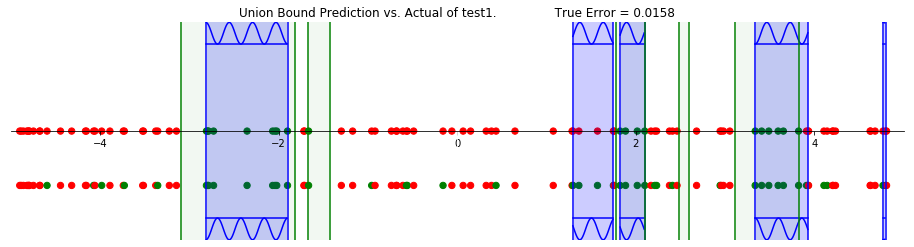

In [34]:
from matplotlib import colors
import matplotlib.transforms as mtransforms
import math

def plot_union(un_int, name = "test"):
    fig = plt.figure(figsize = (16, 4))
    ax = fig.add_subplot(1,1,1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['left'].set_color('white')
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_visible(False)
    plt.xlim(un_int.space)
    plt.ylim([-1,1])
    clrs = un_int.examples[:,2]
    wghts = un_int.examples[:,1]
    xvals = un_int.examples[:,0]
    cmap = colors.ListedColormap(['red', 'green'])
    plt.scatter(xvals,[0]*len(xvals), s = wghts*200/un_int.k, c = clrs, cmap = cmap)#be better as bars not pnts
    est_bnds, permutes = un_int.estimate_intervals()
    error = un_int.calc_error(est_bnds)
    plt.scatter(xvals,[-0.5]*len(xvals), s = wghts*200/un_int.k, c = permutes, cmap = cmap)#be better as bars not pnts
    plt_bnds(est_bnds, ax, 'green', 0.2, est= True)
    tru_bnds = un_int.intervals
    plt_bnds(tru_bnds, ax, 'xkcd:lime', 0.05)
    plt.title(f"Union Bound Prediction vs. Actual of {name}. \
              True Error = {error/abs(un_int.space[0] - un_int.space[1]):.4f}")
    plt.show()
    return est_bnds, error, permutes

def plt_bnds(tru_bnds, ax, clr, alpha = 0.1, est= False):
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    for bnd in tru_bnds:
        x = np.arange(bnd[0] - 0.000001, bnd[-1] + 0.000001, 0.01)
        clr = 'g'
        if est:
            clr = "b"
            plt.plot(x, [0.8]*len(x), c = clr)
            plt.plot(x, np.sin(x*min(24, 24/abs(bnd[0] - bnd[-1]+0.01)))*0.1+0.9, c = clr)
            plt.plot(x, [-0.8]*len(x), c = clr)
            plt.plot(x, np.sin(x*min(24, 24/abs(bnd[0] - bnd[-1]+0.01)))*-0.1 - 0.9, c = clr)
        plt.axvline(x=bnd[0], c = clr)
        plt.axvline(x=bnd[-1], c = clr)
        ax.fill_between(x, 0, 1, where= x >= bnd[0],
                facecolor=clr, alpha=alpha, transform=trans)#x limited to values between bnds, fills between all valid pnts

_, error, permutes = plot_union(test1, "test1")


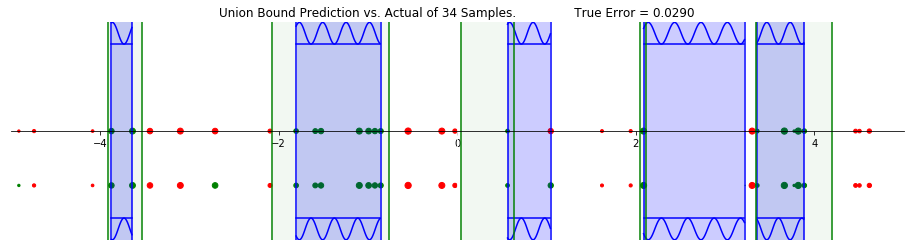

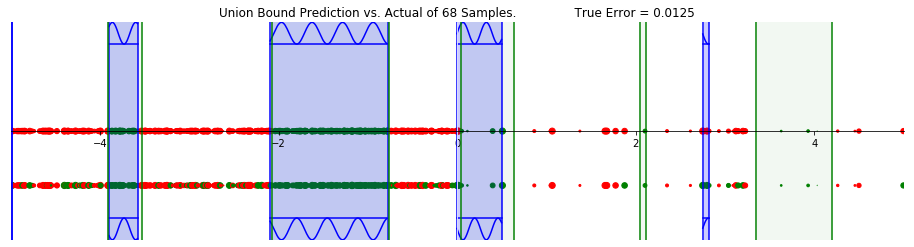

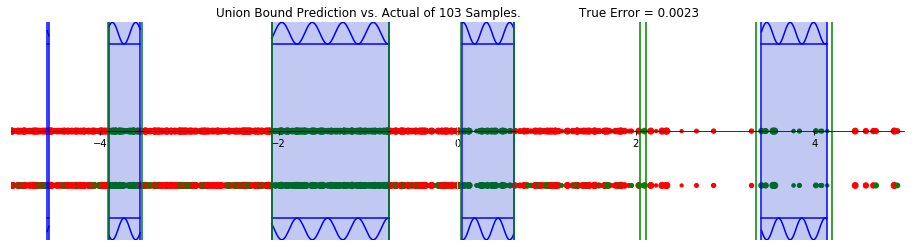

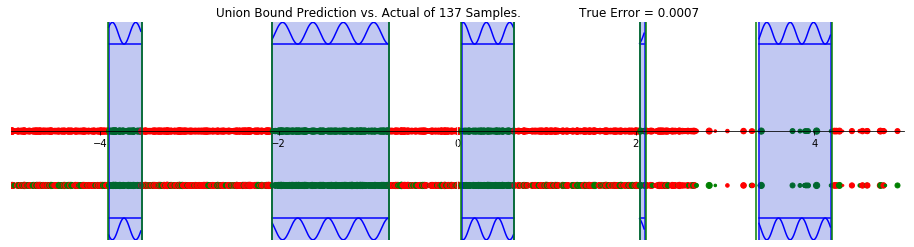

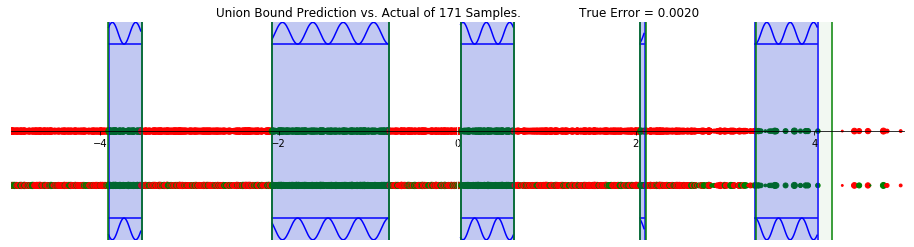

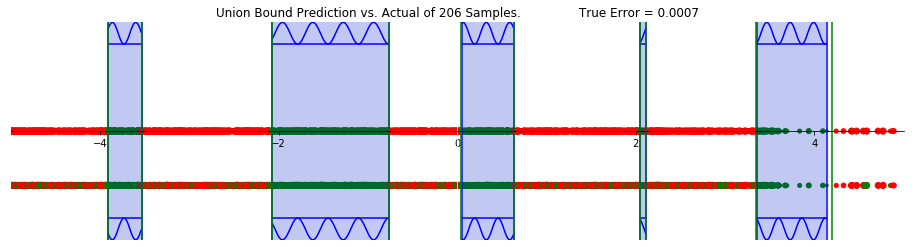

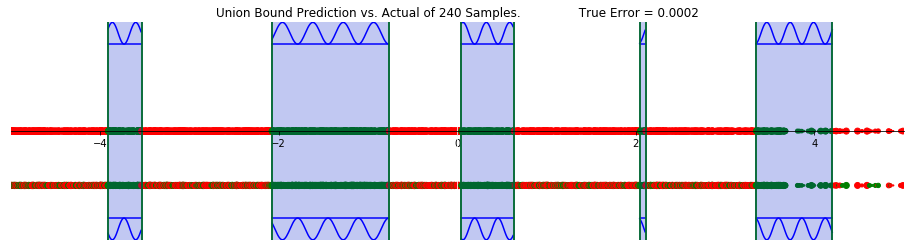

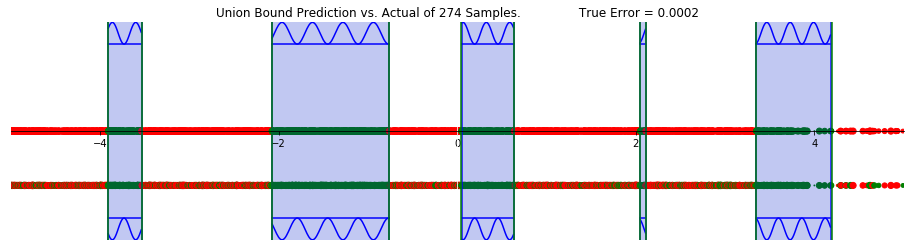

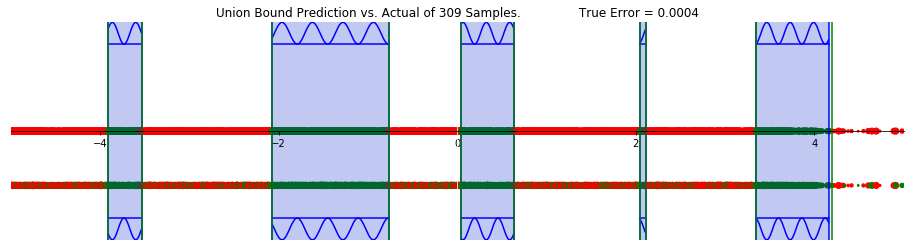

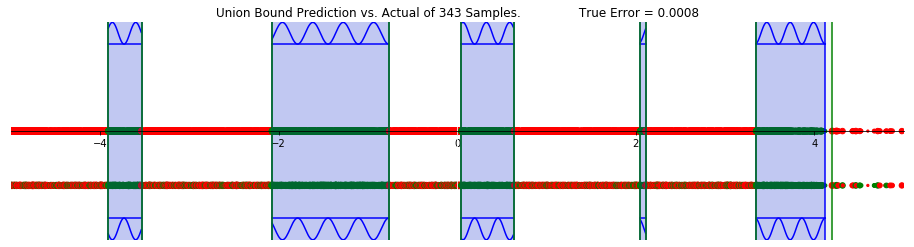

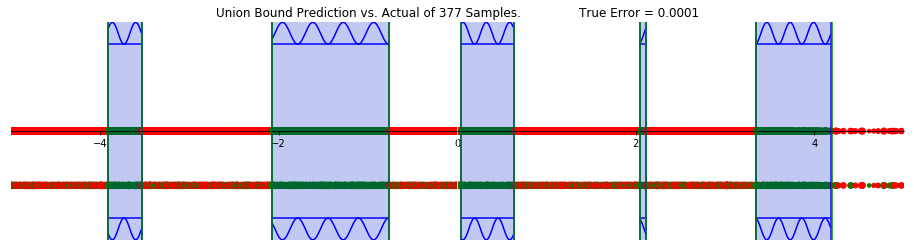

In [ ]:
# from matplotlib import animation
import math

def get_prog(test1, steps = 12, extra = 3, plot_ep = True, calc_gamma = 1, plot_int = False, animate = False):
    calced_intervals = [0]*(steps + extra -1)#only saves 1 set of interval
    calced_error = np.empty([steps + extra - 1, calc_gamma])# will always be float [[0]*calc_gamma for i in range(steps + extra - 1)]
    inc_m = int(test1.theta_m()//steps)
    test1.reset_examples()
    for m in range(1, steps + extra):
        for rp in range(calc_gamma):
            test1.sample(m = m * inc_m)#want to show "improvement" on the same sampleed points
            calced_intervals[m - 1], _ = test1.estimate_intervals()#redone each time w/ the noise given
            calced_error[m - 1, rp] = test1.calc_error(est = calced_intervals[m - 1])
            if rp < calc_gamma - 1:#only appends the last samples drawn
                test1.examples = test1.examples[:-inc_m, :]#removes most reccently sampled
        if plot_int:
            plot_union(test1, name = f"{m * test1.theta_m()//steps} Samples") 
            
    seps = np.arange(inc_m, inc_m*(steps + extra), inc_m)
    mean_ep = np.ravel([np.mean(calced_error[i]) for i in range(steps + extra - 1)])
    emp_gamma = [np.mean(np.ravel(calced_error[i]) >= test1.ep) for i in range(steps + extra - 1)]
    plt.scatter(seps, mean_ep)
    plt.axhline(y = test1.ep)
    plt.title("Mean Epsilon")
    plt.xlabel("Number of Samples")
    plt.ylabel("Epsilon (under uniform distribution)")
    plt.axvline(x = test1.theta_m())
    plt.axvline(x = test1.omega_m())
    plt.show()
    plt.scatter(seps, emp_gamma)
    plt.title(f"Gamma based on {calc_gamma} Repitions")
    plt.xlabel("Number of Samples")
    plt.ylabel("Gamma")
    plt.axhline(y = test1.gamma)
    plt.axvline(x = test1.theta_m())
    plt.axvline(x = test1.omega_m())
    plt.show()

test1 = union_interval(k = 5, noise = 0.3)
get_prog(test1, calc_gamma = 10, animate = False, plot_int = True)